In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd

from models.TrainPlanningOperator3D import PlanningOperator3D

from planners import generaterandompos
from planners import AStarPlanner, FMMPlanner, PlanningOperatorPlanner, testplanneronmaps, plot_2d_map_and_two_paths



Load Gibson Environment

In [2]:
Ntotal = 40

ntest = 8
ntrain = 32

sub = 1
Sx = 48
Sy = 48
Sz = 48

maps = np.load('dataset/occupancy_maps.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[0:8,:,:,:]
# maps = np.repeat(maps, repeats=5, axis=0)



Load Model

In [4]:


# Model
modes = 12
width = 32
nlayers = 1

model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-48-10g/planningoperator_env48_m12_w32_l1_b10_lr3e-3_10g_23sep/n320_lr3.000000e-03_gamma6.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_16342/2039391644.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/igibchunk-dataset-48-10g/planningoperator_env

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=32, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Start [33 37 28]
Goal [14 11 30]

AStar
Success: True 
PathCost: 34.505732175480375 
PlanningTime: 0.13452839851379395

FMM
Success: True 
PathCost: 34.505732175480375 
PlanningTime: 0.03818154335021973

Planning Operator
Success: True 
PathCost: 34.60210849265769 
Total Time 0.24988317489624023


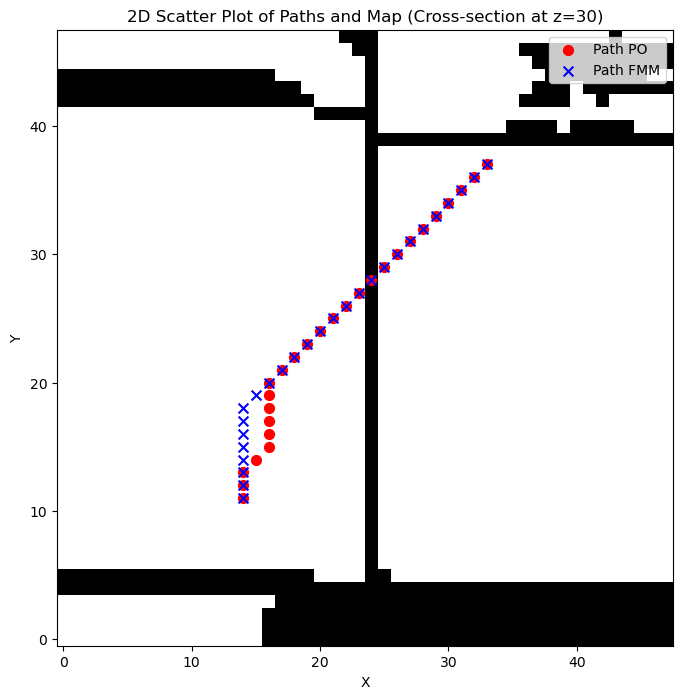

In [16]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

mapx = maps[0,:,:,:]
startx = startpositions[0,:]
print("Start",startx)
goalx = goalpositions[0,:]
# goalx[2] = startx[2]
print("Goal",goalx)


success,pathcost,planningtime, path = AStarPlanner(startx, goalx, mapx)

print("\nAStar\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,planningtime, path_1 = FMMPlanner(startx, goalx, mapx)
print("\nFMM\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,tot_time, path_2 = PlanningOperatorPlanner(startx, goalx, mapx, model)
print("\nPlanning Operator\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nTotal Time", tot_time)


plot_2d_map_and_two_paths(path_2,path_1,mapx,z_index=goalx[2])


Generate Random Positions

In [28]:
startpositions = generaterandompos(maps)
# print(startpositions)
goalpositions = generaterandompos(maps)
# goalpositions[0][2] = startpositions[0][2]
# print(goalpositions)

In [32]:
testplanneronmaps(startpositions,goalpositions,maps,AStarPlanner,printvalues=True)

8it [00:01,  6.43it/s]

Average Path Cost: 27.23704176302906 
Average Planning Time: 0.15514099597930908 
Average Success Rate: 1.0


(27.23704176302906, 0.15514099597930908, 1.0)

In [33]:
testplanneronmaps(startpositions,goalpositions,maps,FMMPlanner,printvalues=True)

8it [00:00, 38.26it/s]

Average Path Cost: 27.249088802676233 
Average Planning Time: 0.026048481464385986 
Average Success Rate: 1.0


(27.249088802676233, 0.026048481464385986, 1.0)

In [34]:
testplanneronmaps(startpositions,goalpositions,maps,PlanningOperatorPlanner,printvalues=True, model=model)

8it [00:02,  3.13it/s]

Average Path Cost: 25.12125909332387 
Average Planning Time: 0.2388797402381897 
Average Success Rate: 0.5


(25.12125909332387, 0.2388797402381897, 0.5)